
# Clustering customers by performance (Recency Frequency Monetary + Refund)

Objective: Find high-value customer groups to prioritize marketing/sales, can pre-filter by region or parent segment


In [ ]:
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

plt.style.use('seaborn-v0_8')

DATA_PATH = Path("../[DATASET C] Retail Supply Chain Sales Analysis/[C] Retail-Supply-Chain-Sales-Analysis.xlsx")


### Filter params and Hyperparams (K)
- `region_filter`: List of areas to filter (`None` for all)
- `segment_filter`: List of parent segments to filter (`None` for all)
- `best_k`: The number of clusters after elbow/silhouette


In [2]:
region_filter = None      # Ex: ['West', 'East']
segment_filter = None     # Ex: ['Corporate', 'Consumer']
best_k = 3                # Configure after viewing graph in EDA

In [3]:
# Read & Apply filter (if exists)
df_orders = pd.read_excel(DATA_PATH, sheet_name="Retails Order Full Dataset")

if region_filter:
    df_orders = df_orders[df_orders['Region'].isin(region_filter)]
if segment_filter:
    df_orders = df_orders[df_orders['Segment'].isin(segment_filter)]

print('Number of lines after filtering:', df_orders.shape)
df_orders.head()


Number of lines after filtering: (9994, 23)


,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Retail Sales People,Product ID,Category,Sub-Category,Product Name,Returned,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,2016-08-11,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,Cassandra Brandow,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,Not,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,2016-08-11,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,Cassandra Brandow,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",Not,731.9400,3,0.00,219.5820
2,3,CA-2016-138688,2016-12-06,2016-12-06,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,Anna Andreadi,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,Not,14.6200,2,0.00,6.8714
3,4,US-2015-108966,2015-11-10,2015-11-10,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,Cassandra Brandow,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,Not,957.5775,5,0.45,-383.0310
4,5,US-2015-108966,2015-11-10,2015-11-10,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,Cassandra Brandow,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,Not,22.3680,2,0.20,2.5164


### Create features for each customer (RFM + behavior)
- RFM: Recency (most recent date), Frequency (number of orders), Monetary (revenue)
- Profit margin, AOV, discount, return rate
- Return frequency by product: rate of products that have been returned

In [4]:
orders = df_orders.copy()
orders['is_return'] = orders['Returned'].str.lower().eq('yes').astype(int)
orders['Order Date'] = pd.to_datetime(orders['Order Date'])
max_date = orders['Order Date'].max()

customer_feat = (
    orders
    .groupby(['Customer ID', 'Segment'])
    .agg(
        recency=('Order Date', lambda s: (max_date - s.max()).days),
        total_sales=('Sales', 'sum'),
        total_profit=('Profit', 'sum'),
        order_lines=('Row ID', 'count'),
        distinct_orders=('Order ID', 'nunique'),
        total_qty=('Quantity', 'sum'),
        avg_discount=('Discount', 'mean'),
        return_rate=('is_return', 'mean'),
    )
)
# RFM
customer_feat['frequency'] = customer_feat['distinct_orders']
customer_feat['monetary'] = customer_feat['total_sales']

# Profit / Unit value profile
customer_feat['profit_margin'] = customer_feat['total_profit'] / customer_feat['total_sales']
customer_feat['avg_order_value'] = customer_feat['total_sales'] / customer_feat['distinct_orders']

# Percentage of products returned
product_return = (
    orders.groupby(['Customer ID', 'Product ID'])['is_return'].max().groupby('Customer ID').agg(['sum','count'])
)
customer_feat['product_return_rate'] = product_return['sum'] / product_return['count']

customer_feat = customer_feat.replace([np.inf, -np.inf], 0).fillna(0)
customer_feat.head()


,,recency,total_sales,total_profit,order_lines,distinct_orders,total_qty,avg_discount,return_rate,frequency,monetary,profit_margin,avg_order_value,product_return_rate
Customer ID,Segment,,,,,,,,,,,,,
AA-10315,Consumer,184,5563.560,-362.8825,11,5,30,0.090909,0.000000,5,5563.560,-0.065225,1112.712000,0.0
AA-10375,Consumer,48,1056.390,277.3824,15,9,41,0.080000,0.000000,9,1056.390,0.262576,117.376667,0.0
AA-10480,Consumer,259,1790.512,435.8274,12,4,36,0.016667,0.000000,4,1790.512,0.243409,447.628000,0.0
AA-10645,Consumer,233,5086.935,857.8033,18,6,64,0.063889,0.055556,6,5086.935,0.168629,847.822500,0.0
AB-10015,Consumer,445,886.156,129.3465,6,3,13,0.066667,0.000000,3,886.156,0.145964,295.385333,0.0


### Normalize and find the right number of clusters (elbow + silhouette)


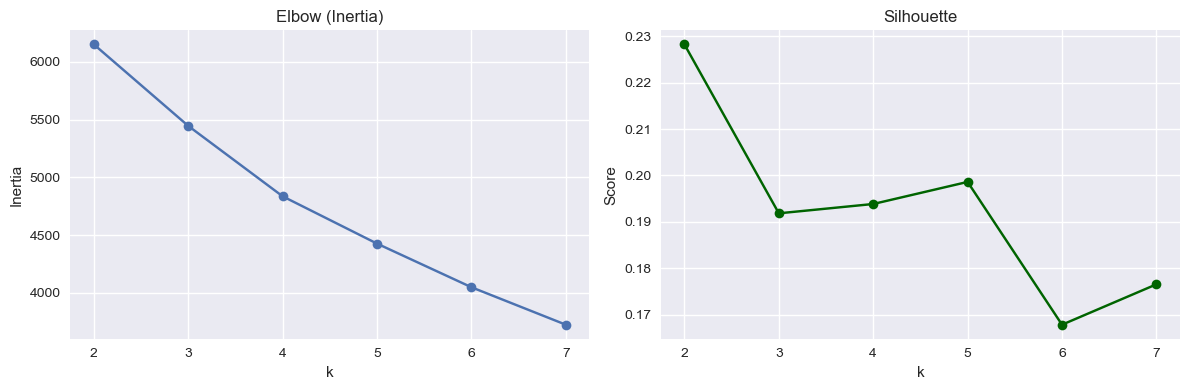

In [5]:
feature_cols = [
    'recency', 'frequency', 'monetary',
    'total_profit', 'profit_margin', 'avg_order_value',
    'order_lines', 'total_qty', 'avg_discount',
    'return_rate', 'product_return_rate'
]
X = customer_feat[feature_cols]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

ks = range(2, 8)
inertias, silhouettes = [], []
for k in ks:
    km = KMeans(n_clusters=k, random_state=42, n_init=20)
    labels = km.fit_predict(X_scaled)
    inertias.append(km.inertia_)
    silhouettes.append(silhouette_score(X_scaled, labels))

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(list(ks), inertias, marker='o')
ax[0].set_title('Elbow (Inertia)')
ax[0].set_xlabel('k')
ax[0].set_ylabel('Inertia')
ax[1].plot(list(ks), silhouettes, marker='o', color='darkgreen')
ax[1].set_title('Silhouette')
ax[1].set_xlabel('k')
ax[1].set_ylabel('Score')
plt.tight_layout()
plt.show()


### Training the KMeans model
Adjust `best_k` after looking at the two graphs above (default = 3).


In [6]:
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=20)
customer_feat['cluster'] = kmeans.fit_predict(X_scaled)
customer_feat.head()


,,recency,total_sales,total_profit,order_lines,distinct_orders,total_qty,avg_discount,return_rate,frequency,monetary,profit_margin,avg_order_value,product_return_rate,cluster
Customer ID,Segment,,,,,,,,,,,,,,
AA-10315,Consumer,184,5563.560,-362.8825,11,5,30,0.090909,0.000000,5,5563.560,-0.065225,1112.712000,0.0,2
AA-10375,Consumer,48,1056.390,277.3824,15,9,41,0.080000,0.000000,9,1056.390,0.262576,117.376667,0.0,0
AA-10480,Consumer,259,1790.512,435.8274,12,4,36,0.016667,0.000000,4,1790.512,0.243409,447.628000,0.0,2
AA-10645,Consumer,233,5086.935,857.8033,18,6,64,0.063889,0.055556,6,5086.935,0.168629,847.822500,0.0,0
AB-10015,Consumer,445,886.156,129.3465,6,3,13,0.066667,0.000000,3,886.156,0.145964,295.385333,0.0,2


### Clustering Result Analysis
- Cluster Size, Revenue/Profit Contribution
- Feature Profile (Median) to Reduce Outliers
- Original Segment Distribution in Each Cluster

In [7]:
cluster_size = customer_feat.groupby('cluster').size().rename('customers')
cluster_revenue = customer_feat.groupby('cluster')[['total_sales', 'total_profit']].sum()
cluster_profile = customer_feat.groupby('cluster')[feature_cols].median()
segment_mix = (
    customer_feat.reset_index()
    .pivot_table(index='cluster', columns='Segment', values='Customer ID', aggfunc='count', fill_value=0)
)

print('Scale & contribution:', pd.concat([cluster_size, cluster_revenue], axis=1))
print('Cluster profile (median features): ', cluster_profile)
print('Distribution of the original Segment in each cluster:', segment_mix)

Scale & contribution:          customers   total_sales  total_profit
cluster                                       
0              309  1.012403e+06    91222.4576
1               79  6.725831e+05   147578.4796
2              405  6.122152e+05    47596.0845
Cluster profile (median features):           recency  frequency  monetary  total_profit  profit_margin  \
cluster                                                              
0           57.0        8.0  3036.547      318.4625       0.121892   
1           69.0        7.0  7721.714     1623.4019       0.235721   
2          152.0        5.0  1256.944      122.3612       0.136761   

         avg_order_value  order_lines  total_qty  avg_discount  return_rate  \
cluster                                                                       
0             370.685333         16.0       63.0      0.160000          0.0   
1            1056.592933         17.0       67.0      0.104762          0.0   
2             282.976833          8.0   

### Visualize 2D by PCA
Helps visualize the separation of clusters on the normalized feature space.

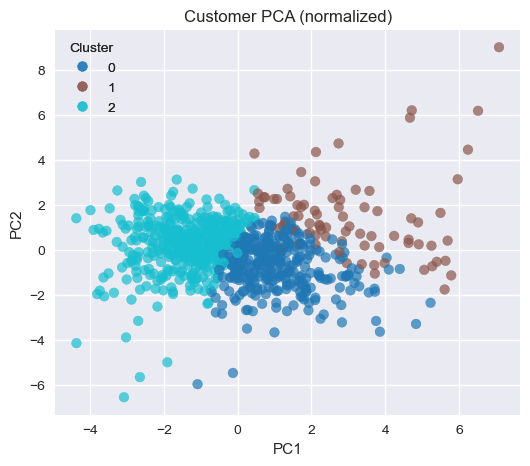

In [8]:
pca = PCA(n_components=2, random_state=42)
coords = pca.fit_transform(X_scaled)

# Lấy tọa độ tâm các cụm sau khi transform bằng PCA
centers_pca = pca.transform(kmeans.cluster_centers_)

fig, ax = plt.subplots(figsize=(6, 5))
scatter = ax.scatter(coords[:, 0], coords[:, 1], c=customer_feat['cluster'], cmap='tab10', alpha=0.7)
# Vẽ tâm các cụm
ax.scatter(centers_pca[:, 0], centers_pca[:, 1], c='red', s=100, marker='X', label='Centroids')

legend1 = ax.legend(*scatter.legend_elements(), title="Cluster")
ax.add_artist(legend1)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_title('Customer PCA (normalized)')
ax.legend()
plt.show()


### => Suggested Action
- Clusters with high `monetary/total_profit`, high `profit_margin`: focus on Upsell/Cross-sell, prioritize delivery SLA.

- Clusters with high revenue but low `profit_margin` or high `avg_discount`: optimize price/promotion, consider reducing discounts.

- Clusters with high `return_rate`/`product_return_rate`: review product quality/logistics, return policy.